## skpro introduction notebook

**Set-up instructions:** On binder, this should run out-of-the-box.

To run this notebook as intended, ensure that `skpro` with basic dependency requirements is installed in your python environment.

`skpro` provides `scikit-learn`-like, `scikit-base` compatible interfaces to:

* tabular **supervised regressors with probabilistic prediction modes** - interval, quantile and distribution predictions
* **performance metrics to evaluate probabilistic predictions**, e.g., pinball loss, empirical coverage, CRPS
* **reductions** to turn non-probabilistic, `scikit-learn` regressors into probabilistic `skpro` regressors, such as bootstrap or conformal
* tools for building **pipelines and composite machine learning models**, including tuning via probabilistic performance metrics
* symbolic an lazy **probability distributions** with a value domain of `pandas.DataFrame`-s and a `pandas`-like interface

**Section 1** provides an overview of common **probabilistic supervised regression workflows** supported by `skpro`.

**Section 2** gives an introduction to the different **prediction modes, performance metrics, and benchmarking tools**.

**Section 3** discusses **advanced composition patterns**, including various ways to add probabilistic capability to any `sklearn` regressor, pipeline building, tuning, ensembling.

**Section 4** gives an introduction to how to write **custom estimators** compliant with the `skpro` interface.

In [ ]:
import warnings

# import numpy as np
# import pandas as pd

# hide warnings
warnings.filterwarnings("ignore")

## 1. Basic probabilistic supervised regression workflows <a class="anchor" id="chapter1"></a>

`skpro` revolves around supervised probabilistic regressors:

* `fit(X, y)` with tabular features `X`, labels `y`, same rows, both `pd.DataFrame`
* `predict_interval(X_test)` for interval predictions of labels
* `predict_quantiles(X_test)` for quantile predictions of labels
* `predict_var(X_test)` for variance predictions of labels
* `predict(X_test)` for mean predictions
* `predict_proba(X_test)` for distributional prediction

### 1.1 basic deployment workflow

`skpro` regressors are used via `fit` then `predict_proba` etc.

Same as `sklearn` regressors - `X` and `y` should be `pd.DataFrame` (`numpy` is also ok but not recommended)

In [ ]:

from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from skpro.regression.residual import ResidualDouble

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_new, y_train, _ = train_test_split(X, y)

# step 2: specifying the regressor
# example - random forest for mean prediction
# linear regression for variance prediction
reg_mean = RandomForestRegressor()
reg_resid = LinearRegression()
reg_proba = ResidualDouble(reg_mean, reg_resid)

# step 3: fitting the model to training data
reg_proba.fit(X_train, y_train)

# step 4: predicting labels on new data

# probabilistic prediction modes - pick any or multiple
# we show the return types in detail below

# full distribution prediction
y_pred_proba = reg_proba.predict_proba(X_new)

# interval prediction
y_pred_interval = reg_proba.predict_interval(X_new, coverage=0.9)

# quantile prediction
y_pred_quantiles = reg_proba.predict_quantiles(X_new, alpha=[0.05, 0.5, 0.95])

# variance prediction
y_pred_var = reg_proba.predict_var(X_new)

# mean prediction is same as "classical" sklearn predict, also available
y_pred_mean = reg_proba.predict(X_new)

### 1.1.1 distribution predictions

`y_pred_proba` is an `skpro` distribution - it has index and columns like `pd.DataFrame`

"we predict that true labels are distributed according to `y_pred_proba`"

(here: distribution marginal by row/columns)

In [ ]:
y_pred_proba = reg_proba.predict_proba(X_new)
y_pred_proba

`skpro` distribution objects are pandas-like

In [ ]:
y_pred_proba.shape

In [ ]:
y_pred_proba.index  # same index as X_new

In [6]:
y_pred_proba.columns  # same columns as X_new

Index(['target'], dtype='object')

distribution objects have `sample` and methods such as `mean`, `var`:

In [7]:
y_pred_proba.sample().head()

,target
36,226.800503
220,107.150519
420,91.429409
350,275.793488
112,164.841224


In [8]:
y_pred_proba.mean().head()

,target
36,215.73
220,95.61
420,101.67
350,252.81
112,154.53


In [9]:
y_pred_proba.var().head()

,target
36,315.951596
220,237.688334
420,593.345288
350,331.345406
112,347.472328


### 1.1.2 interval predictions

interval prediction `y_pred_interval` is a `pd.DataFrame`:

* rows are the same as `X_new`
* columns indicate variables, nominal coverage, and bottom/upper bound

"we predict that value in row falls between bottom/upper with 90% chance"

In [10]:
y_pred_interval = reg_proba.predict_interval(X_new, coverage=0.9)
y_pred_interval.head()

target            
            0.9            
          lower       upper
36   186.492682  244.967318
220   70.251055  120.968945
420   61.603537  141.736463
350  222.868901  282.751099
112  123.868926  185.191074

### 1.1.3 quantile predictions

quantile prediction `y_pred_quantiles` is a `pd.DataFrame`:

* rows are the same as `X_new`
* columns indicate variables, quantile points

"we predict the 5%, 50%, 95% quantile points for the row to be here"

In [11]:
y_pred_quantiles = reg_proba.predict_quantiles(X_new, alpha=[0.05, 0.5, 0.95])
y_pred_quantiles.head()

target                    
           0.05    0.50        0.95
36   186.492682  215.73  244.967318
220   70.251055   95.61  120.968945
420   61.603537  101.67  141.736463
350  222.868901  252.81  282.751099
112  123.868926  154.53  185.191074

### 1.1.4 mean and variance predictions

mean and variance predictions `y_pred_mean`, `y_pred_var` are `pd.DataFrame`-s:

* rows are the same as `X_new`
* columns are the same as `X_new`

entries are predictive mean and variance in row/column

In [12]:
y_pred_mean = reg_proba.predict(X_new)
y_pred_var = reg_proba.predict_var(X_new)

In [13]:
y_pred_mean.head()

,target
36,215.73
220,95.61
420,101.67
350,252.81
112,154.53


In [14]:
y_pred_var.head()

,target
36,315.951596
220,237.688334
420,593.345288
350,331.345406
112,347.472328


this is the same as taking the distribution prediction and taking mean/variance

(for distribution objects that estimate these precisely)

In [15]:
y_pred_proba.mean().head()

,target
36,215.73
220,95.61
420,101.67
350,252.81
112,154.53


In [16]:
y_pred_proba.var().head()

,target
36,315.951596
220,237.688334
420,593.345288
350,331.345406
112,347.472328


### 1.2 simple evaluation workflow for probabilistic predictions

for simple evaluation:

1. split the data into train/test set
2. make predictions of either type for test features
3. compute metric on test set, comparing test predictions to hend out test labels

Note:

* metrics will compare tabular ground truth to probabilistic prediction
* the metric will needs to be of a compatible type, e.g., for proba predictions

In [17]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from skpro.metrics import CRPS
from skpro.regression.residual import ResidualDouble

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# step 2: specifying the regressor
# example - linear regression for mean prediction
# random forest for variance prediction
reg_mean = LinearRegression()
reg_resid = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, reg_resid)

# step 3: fitting the model to training data
reg_proba.fit(X_train, y_train)

# step 4: predicting labels on new data
y_pred_proba = reg_proba.predict_proba(X_test)

# step 5: specifying evaluation metric
metric = CRPS()

# step 6: evaluat metric, compare predictions to actuals
metric(y_test, y_pred_proba)

31.32745662219804

how do we know that metric is of right type? Via `scitype:y_pred` tag

In [18]:
metric.get_tags()
# scitype:y_pred is pred_proba - for proba predictions

{'estimator_type': 'estimator',
 'object_type': 'metric',
 'reserved_params': ['multioutput', 'score_average'],
 'scitype:y_pred': 'pred_proba',
 'lower_is_better': True}

how do we find metrics for a prediction type?

In [19]:
from skpro.registry import all_objects

all_objects("metric", as_dataframe=True, return_tags="scitype:y_pred")

,name,object,scitype:y_pred
0,CRPS,<class 'skpro.metrics._classes.CRPS'>,pred_proba
1,ConstraintViolation,<class 'skpro.metrics._classes.ConstraintViola...,pred_interval
2,EmpiricalCoverage,<class 'skpro.metrics._classes.EmpiricalCovera...,pred_interval
3,LogLoss,<class 'skpro.metrics._classes.LogLoss'>,pred_proba
4,PinballLoss,<class 'skpro.metrics._classes.PinballLoss'>,pred_quantiles
5,SquaredDistrLoss,<class 'skpro.metrics._classes.SquaredDistrLoss'>,pred_proba


extra note: quantile metrics can be applied to interval predictions as well

more details on metrics below

### 1.2.1 diagnostic visualisations

some useful diagnostic visualisations: variants of crossplots for probabilistic predictions

A. crossplot ground truth vs prediction intervals.

Works with both proba and interval predictions.

What to look for: intervals shouhld cut through the x = y line (green points)

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

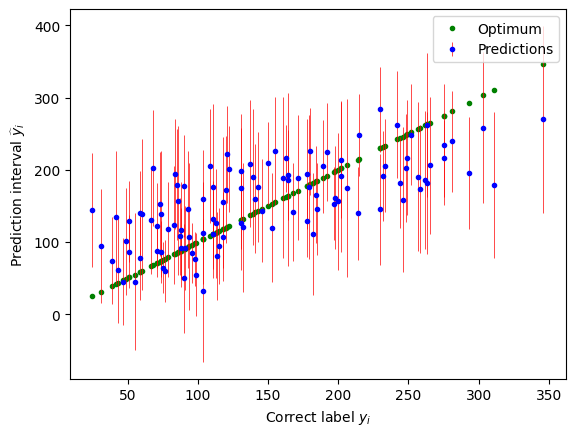

In [20]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

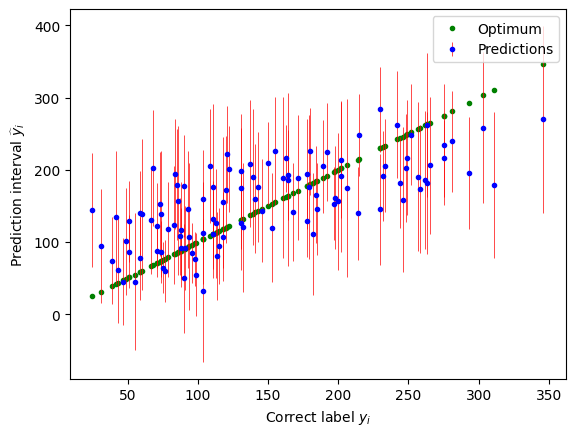

In [21]:
from skpro.utils.plotting import plot_crossplot_interval

y_pred_interval = reg_proba.predict_interval(X_test, coverage=0.9)
plot_crossplot_interval(y_test, y_pred_interval)

B. crossplot residuals vs predictive standard deviation

Works with both proba and variance predictions.

What to look for: should be close to a line, high linear correlation

<Axes: xlabel='Absolute errors $|y_i - \\widehat{y}_i|$', ylabel='Predictive standard deviation of $\\widehat{y}_i$'>

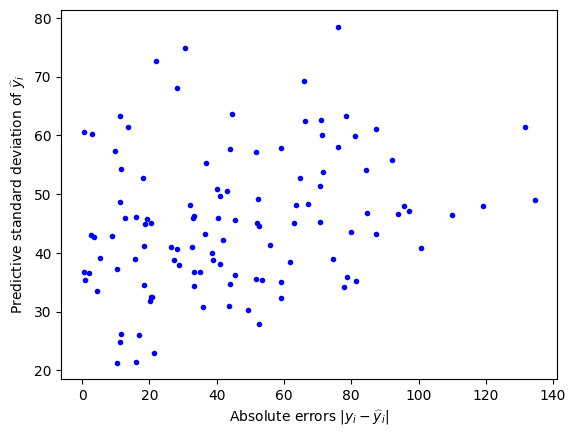

In [ ]:
from skpro.utils.plotting import plot_crossplot_std

plot_crossplot_std(y_test, y_pred_proba)

In [ ]:
from skpro.utils.plotting import plot_crossplot_std

y_pred_var = reg_proba.predict_var(X_test)
plot_crossplot_std(y_test, y_pred_var)

C. crossplot ground truth vs loss values

Loss and prediction type should agree.

What to look for: association between accuracy and ground truth value

Diagnostic of which values we can predict more accurately,

e.g., to inform modelling or identify unusual outliers

In [ ]:
from skpro.utils.plotting import plot_crossplot_loss

crps_metric = CRPS()
plot_crossplot_loss(y_test, y_pred_proba, crps_metric)

### 1.3 searching for probabilistic regressors and metrics

all objects in `skpro` are indexed via the `registry` utility `all_objects`.

To find probabilistic supervised regressors, use `all_objects` with the type `regressor_proba`:

In [ ]:
from skpro.registry import all_objects

all_objects("regressor_proba", as_dataframe=True).head()

a full list can also be found in the online API reference.

## 3. Advanced composition patterns <a class="anchor" id="chapter3"></a>

we introduce a number of composition patterns available in `skpro`:

* reducer-wrappers that turn `sklearn` regressors into probabilistic ones
* pipelines of `sklearn` transformers with `skpro` regressors
* tuning `skpro` probabilistic regressors via grid/random search, minimizing a probabilistic metric
* ensembling multiple `skpro` probabilistic regressors

data used in this section:

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

evaluation metric used in this section:

In [ ]:
crps = CRPS()

### 3.1 Reducers to turn `sklearn` regressors probabilistic <a class="anchor" id="section3_1"></a>

there are many common algorithms that turn a non-probabilistic tabular regressor probabilistic

formally, this is a type of "reduction" - of probabilistic supervised tabular to non-probabilistic supervised tabular

Examples:

* predicting variance equal to training residual variance - `ResidualDouble` with standard settings
    * or other unconditional distribution estimate for residuals
* "squaring the residual" two-step prediction - `ResidualDouble`
* boostrap prediction intervals - `BootstrapRegressor`
* conformal prediction intervals - contributions appreciated :-)
* natural gradient boosting aka NGBoost - contributions appreciated :-)

### 3.1.1 constant variance prediction <a class="anchor" id="section3_1_1"></a>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# estimator specification - use any sklearn regressor for reg_mean
reg_mean = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, cv=KFold(5))
# cv is used to estimate out-of-sample residual variance via 5-fold CV
# note - in-sample predictions will usually underestimate the variance!

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
crps(y_test, y_pred_proba)

In [ ]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

### 3.1.2 two-step residual prediction <a class="anchor" id="section3_1_2"></a>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# estimator specification - use any sklearn regressor for reg_mean and reg_resid
reg_mean = RandomForestRegressor()
reg_resid = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, estimator_resid=reg_resid, cv=KFold(5))
# cv is used to estimate out-of-sample residual variance via 5-fold CV

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
crps(y_test, y_pred_proba)

In [ ]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

### 3.1.3 bootstrap prediction intervals <a class="anchor" id="section3_1_3"></a>

In [ ]:
from sklearn.linear_model import LinearRegression

from skpro.regression.bootstrap import BootstrapRegressor

# estimator specification - use any sklearn regressor for reg_mean
reg_mean = LinearRegression()
reg_proba = BootstrapRegressor(reg_mean, n_bootstrap_samples=100)

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
crps(y_test, y_pred_proba)

In [ ]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)